<a href="https://colab.research.google.com/github/itissandeep98/ML-Assignments/blob/master/ML_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocess

In [122]:
class MyPreProcessor():
    """
    My steps for pre-processing for the three datasets.
    """

    def __init__(self):
        pass

    def pre_process(self, dataset):
        """
        Reading the file and preprocessing the input and output.
        Note that you will encode any string value and/or remove empty entries in this function only.
        Further any pre processing steps have to be performed in this function too. 

        Parameters
        ----------

        dataset : integer with acceptable values 0, 1, or 2
        0 -> Abalone Dataset
        1 -> VideoGame Dataset
        2 -> BankNote Authentication Dataset
        
        Returns
        -------
        X : 2-dimensional numpy array of shape (n_samples, n_features)
        y : 1-dimensional numpy array of shape (n_samples,)
        """     

        if dataset == 0:
            df=pd.read_csv('/content/Dataset.data',delim_whitespace=True,header=None)
            df.sample(frac=1)
            df[0].replace('M',1,inplace=True)
            df[0].replace('F',2,inplace=True)
            df[0].replace('I',3,inplace=True)
            
            data=df.to_numpy()
            X=data[:,:-1]
            y=data[:,-1]

        elif dataset == 1:
            df=pd.read_csv('/content/VideoGameDataset.csv')
            df=df[['Critic_Score','Global_Sales','User_Score']]
            df=df.sample(frac=1)

            df['Critic_Score'].fillna(df['Critic_Score'].median(), inplace=True)
            df['User_Score'].replace(to_replace = 'tbd', value = np.nan,inplace=True)
            df['User_Score']=df['User_Score'].astype(np.float)
            df['User_Score'].fillna(df['User_Score'].median(), inplace=True)

            data=df.to_numpy()
            X=data[:,:-1]
            y=data[:,-1]

        elif dataset == 2:
            # Implement for the banknote authentication dataset
            pass

        return X, y


# Linear Regression

In [150]:
class MyLinearRegression():
  """
	My implementation of Linear Regression.
	"""
  def __init__(self):
    pass

  def cross_validation(self,X,y,epoch=1000,alpha=0.01,k=10,lossfunc=1):
    """
    performs k fold cross validation on the given dataset

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features) 

    y : 1-dimensional numpy array of shape (n_samples,)

    k : Number of folds the data needs to be splitted into

    epoch : Number of times gradient descent has to run

    alpha : Learning rate of gradient descent

    lossfunc: determines which loss function to call

    Returns
    -------
    derv : derivative of cost at the value theta
    err  : Error/cost in prediction at the value theta
    """
    m=X.shape[0] # number of samples

    split_start=0 # initial split's first index
    split_end=m//k # initial split's last index

    theta_list=[0]*k  # initialized theta
    training_loss_list=[0]*k  # initialized list to store all the training loss from every fold
    validation_loss_list=[0]*k # initialized list to store all the validation loss from every fold

    error_min=float("inf")
    idx=0

    for i in range(k):

      # Extracting X and y for train and test set
      X_train=np.concatenate((X[:split_start],X[split_end:]),axis=0)
      y_train=np.concatenate((y[:split_start],y[split_end:]),axis=0)

      X_test=X[split_start:split_end]
      y_test=y[split_start:split_end]

      self.fit(X_train,y_train,X_test,y_test,epoch,alpha,lossfunc) # calculating model parameters by running the gradient descent

      # storing the results of current fold in the array
      theta_list[i]=self.theta
      training_loss_list[i]=self.training_loss
      validation_loss_list[i]=self.validation_loss

      split_start=split_end # updating slice parameters
      split_end+=m//k

      error=training_loss_list[i][-1]


      # if the error in this fold is minimum of all errors seen upto now then update it and store the fold number
      if(error<error_min):
        idx=i
        error_min=error
    
    # final storing the values associated with minimum error 
    self.theta=theta_list[idx]
    self.training_loss=training_loss_list[idx]
    self.validation_loss=validation_loss_list[idx]

  def MSE(self,X,y,theta):
    """
    finding Mean Squared Error based on current model parameters

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features)

    y : 1-dimensional numpy array of shape (n_samples,)

    theta : Value of theta at which derivative of cost has to be found

    Returns
    -------
    derv : derivative of cost at the value theta
    err  : Error/cost in prediction at the value theta
    """
    m=len(y)

    X_trans=np.transpose(X)                                           # Transpose of vector X
    err=X.dot(theta)-y
    derv =(1/m)*(X_trans.dot(err))                         # Calculates X` * ( X*theta - y )
    
    return derv,sum(err**2)/m    
 
  def MAE(self,X,y,theta):
    """
    finding Mean Average Error based on current model parameters

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features)

    y : 1-dimensional numpy array of shape (n_samples,)

    theta : Value of theta at which derivative of cost has to be found

    Returns
    -------
    derv : derivative of cost at the value theta
    err  : Error/cost in prediction at the value theta
    """
    m=len(y)
    err=(1/m)*(X.dot(theta)-y)
    X_trans=X.T
   
    grad=(1/m)*(X_trans.dot(abs(err)/err))
    
    return grad,sum(abs(err))

  def RMSE(self,X,y,theta):
    """
    finding Root Mean Squared Error based on current model parameters

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features)

    y : 1-dimensional numpy array of shape (n_samples,) 

    theta : Value of theta at which derivative of cost has to be found

    Returns
    -------
    derv : derivative of cost at the value theta
    err  : Error/cost in prediction at the value theta
    """
    X_trans=X.T                                               # Transpose of vector X
    y_hat=X.dot(theta)-y
    m=len(y)
   
    err=((1/m)*np.sum((y_hat)**2))**0.5
    derv =(1/m)*(X_trans.dot(y_hat))/err         
    
    return derv,err


  def gradient_descent(self,X,y,X_test,y_test,epochs,alpha,lossfunc):
    """
    Finding theta using the gradient descent method

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

    y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

    X_test : 2-dimensional numpy array of shape (n_samples, n_features) which acts as Testing data.

    y_test : 1-dimensional numpy array of shape (n_samples,) which acts as Testing labels.

    epochs : Number of times gradient descent has to run

    alpha : Learning rate of gradient descent

    lossfunc: determines which loss function to call

    Returns
    -------
    theta : Calculated value of theta on given test set (X,y) with learning rate alpha 

    training_loss: Calculated training loss at every theta

    tvalidation_loss: Calculated validation loss at every theta
    """
   
    theta= np.zeros((X.shape[1],))                      # created a column vector theta of length equal to number of features in X with all the initial values 0
    
    training_loss=np.array([])  # initializing array to store training loss at every value of theta
    validation_loss= np.array([]) # initializing array to store validation loss at every value of theta

    # print("-*"*20)

    for i in range(epochs): 
      if(lossfunc==1): 
        derv,train_loss=self.RMSE(X,y,theta)   
      elif(lossfunc==2):   
        derv,train_loss=self.MAE(X,y,theta)
      else:
        derv,train_loss=self.MSE(X,y,theta)
      training_loss=np.append(training_loss,train_loss)

      # if(i%400==0):
      #   print("Iteration:",i,"Training error:",train_loss)

      if(X_test is not None): # calculate validation loss only if test set is provided
        if(lossfunc==1):
          derv_val,val_loss=self.RMSE(X_test,y_test,theta)   
        elif(lossfunc==2):   
          derv_val,val_loss=self.MAE(X_test,y_test,theta)
        else:
          derv_val,val_loss=self.MSE(X_test,y_test,theta)
      
        validation_loss=np.append(validation_loss,val_loss)
        
      theta=theta-alpha*derv
      
  
    return theta,training_loss,validation_loss

  def fit(self, X, y,X_test=None,y_test=None,epoch=400,alpha=0.01,lossfunc=1):
    """
    Fitting (training) the linear model.

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

    y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

    Returns
    -------
    self : an instance of self
    """

    X=np.concatenate((np.ones((X.shape[0],1)),X),axis=1) # Adding a bias variable i.e columns of 1 to data

    if(X_test is not None): # if validation set is provided then add a bias variable i.e columns of 1 to data
      X_test=np.concatenate((np.ones((X_test.shape[0],1)),X_test),axis=1)
   
    X_trans=np.transpose(X)
    if(lossfunc==4):
      try:
        self.theta = np.linalg.inv(X_trans.dot(X)).dot(X_trans).dot(y)  # using the normal eqn, theta = inv(X`*X)*X`*y
      except:
        self.theta,self.training_loss,self.validation_loss = self.gradient_descent(X,y,X_test,y_test,epoch,alpha,lossfunc=1) # using the gradient descent method with RMSE loss function if the given data is non invertible
    else: 
      self.theta,self.training_loss,self.validation_loss = self.gradient_descent(X,y,X_test,y_test,epoch,alpha,lossfunc) # using the gradient descent method with given number of epochs and learning rate
      

    # fit function has to return an instance of itself or else it won't work with test.py
    return self


  def predict(self, X):
    """
    Predicting values using the trained linear model.

    Parameters
    ----------
    X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

    Returns
    -------
    y : 1-dimensional numpy array of shape (n_samples,) which contains the predicted values.
    """
    X=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    y=np.dot(X,self.theta)
    # return the numpy array y which contains the predicted values
    return y

  def plot_loss(self):
    print("Thetas:",self.theta)
    print("Training Loss:",self.training_loss[-1])
    print("Validation Loss:",self.validation_loss[-1])
    
    x=np.arange(self.training_loss.shape[0])
    plt.plot(x,self.training_loss,color="g", label="Training Loss")
    plt.plot(x,self.validation_loss,color="r",label="Validation Loss")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    


## Dataset1

Thetas: [2.5769917  1.02920677 1.62578726 1.29796717 0.47071786 3.09257129
 1.15003946 0.65734139 1.01654006]
Training Loss: 2.703392422960864
Validation Loss: 4.676936786313666


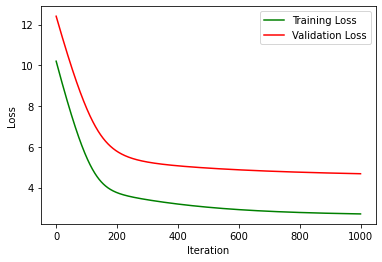

In [151]:
preprocessor = MyPreProcessor()
X, y = preprocessor.pre_process(0)

linear = MyLinearRegression()
linear.cross_validation(X,y,lossfunc=1)
linear.plot_loss()



## Dataset2

Thetas: [0.00165914 0.1036596  0.00030808]
Training Loss: 1.0408345429164667
Validation Loss: 1.0789948404798702


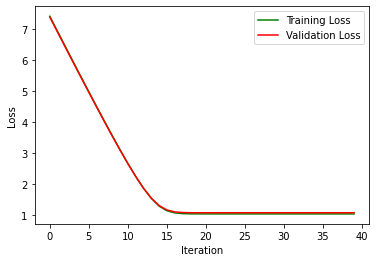

In [152]:
preprocessor = MyPreProcessor()
X, y = preprocessor.pre_process(1)

linear = MyLinearRegression()
linear.cross_validation(X,y,epoch=40,alpha=0.0001,lossfunc=1)
linear.plot_loss()




# Logistic Regression

In [ ]:
class MyLogisticRegression():
	"""
	My implementation of Logistic Regression.
	"""

	def __init__(self):
		pass

	def sigmoid(self,z):
		"""
		Find the sigmoid value of z

		Parameters
		----------
		z : 1-dimensional numpy array of shape (n_samples,)

		Returns
		-------
		value of z in sigmoid function
		"""
		return 1/(1+np.exp(-z))
	
	def cost_diff(self,X,y,theta):
		"""
		Find Log Loss error in current model parameters

		Parameters
		----------
		X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

		y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

		theta : Value of theta at which derivative of cost has to be found

		Returns
		-------
		derv : derivative of cost at the value theta
		"""
		X_trans=np.transpose(X)										                       # Transpose of vector X
		
		derv =(X_trans.dot(self.sigmoid(X.dot(theta))-y))				         # Calculates X` * ( sigmoid(X*theta) - y )
		return derv

	
	def gradient_descent(self,X,y,epochs=100,alpha=0.01):
		"""
		Finding theta using the gradient descent model

		Parameters
		----------
		X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

		y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

		epochs : Number of times gradient descent has to run

		alpha : Learning rate of gradient descent

		Returns
		-------
		theta : Calculated value of theta on given test set (X,y) with learning rate alpha 
		"""
		m=len(y)
		theta=np.transpose(np.array([0]*len(X[0])))                     # created a column vector theta of length equal to number of features in X with all the initial values 0
		
		for i in range(epochs):
		  theta=theta-(alpha/m)*self.cost_diff(X,y,theta)
		
		return theta

	def fit(self, X, y):
		"""
		Fitting (training) the logistic model.

		Parameters
		----------
		X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

		y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

		Returns
		-------
		self : an instance of self
		"""
		self.theta = self.gradient_descent(X,y,200,0.01)              # using the gradient descent method with given number of epochs and learning rate

		# fit function has to return an instance of itself or else it won't work with test.py
		return self

	def predict(self, X):
		"""
		Predicting values using the trained logistic model.

		Parameters
		----------
		X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

		Returns
		-------
		y : 1-dimensional numpy array of shape (n_samples,) which contains the predicted values.
		"""
		y=self.sigmoid(X.dot(self.theta))
	
		# return the numpy array y which contains the predicted values
		return y

# Testing


In [29]:
Xtrain = np.array([[1, 2, 3], 
                   [4, 5, 6]])
ytrain = np.array([1, 2])

Xtest = np.array([[7, 8, 9]])
ytest = np.array([3])

print('Linear Regression')

linear = MyLinearRegression()
linear.fit(Xtrain, ytrain)

ypred = linear.predict(Xtest)

print('Predicted Values:', ypred)
print('True Values:', ytest)

# print('Logistic Regression')

# logistic = MyLogisticRegression()
# logistic.fit(Xtrain, ytrain)

# ypred = logistic.predict(Xtest)

# print('Predicted Values:', ypred)
# print('True Values:', ytest)

Linear Regression
Predicted Values: [3.47084775]
True Values: [3]
